# Performance assessment

Calculate performance metrics of the GEE-based classifiers using validation data constructed at the U.S. Geological Survey Benchmark glaciers.

In [ ]:
# NOTE: This notebook uses a couple extra packages for reading the validation data and plotting. 
# To install, uncomment and run the following:
# !micromamba install seaborn geopandas -y

In [1]:
import os
import ee 
from glob import glob
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, Point
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Define paths in directory

Assumes the "glasee_pipeline_utils.py" file and "models_validation_data" folder are in the same directory as this notebook.


In [2]:
# Load utility functions for querying imagery
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
import glasee_pipeline_utils as utils

# Define output directory
out_dir = os.getcwd()

# Load validation points file names
val_dir = os.path.join(os.getcwd(), 'models_validation_data')
val_fns = sorted(glob(os.path.join(val_dir, '*classified_points.csv')))
val_fns

['/Users/raineyaberle/Research/PhD/snow_cover_mapping/glasee/performance assessment/models_validation_data/Landsat_manually_classified_points.csv',
 '/Users/raineyaberle/Research/PhD/snow_cover_mapping/glasee/performance assessment/models_validation_data/PlanetScope_manually_classified_points.csv',
 '/Users/raineyaberle/Research/PhD/snow_cover_mapping/glasee/performance assessment/models_validation_data/Sentinel-2_SR_manually_classified_points.csv',
 '/Users/raineyaberle/Research/PhD/snow_cover_mapping/glasee/performance assessment/models_validation_data/Sentinel-2_TOA_manually_classified_points.csv']

## Authenticate GEE

Change the project name to your respective GEE project.

In [3]:
project_name = 'ee-raineyaberle'

try:
    ee.Initialize(project=project_name)
except:
    ee.Authenticate()
    ee.Initialize(project=project_name)

## Iterate over datasets

Sentinel-2_SR
Confusion matrix:
 [[1179   17]
 [  55 1463]]
Overall accuracy: 0.9734708916728076
Kappa: 0.946364990783061
F1 Score: [0.9703703703703704, 0.9759839893262173]
Recall: 0.9637681159420289
Precision: 0.9885135135135135


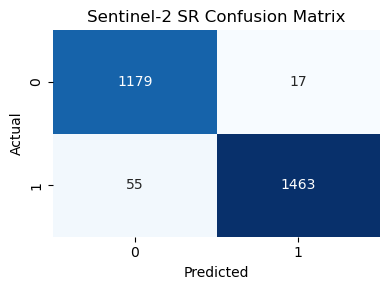


Sentinel-2_TOA
Confusion matrix:
 [[1182   16]
 [ 127 1391]]
Overall accuracy: 0.9473490427098674
Kappa: 0.8942485095222846
F1 Score: [0.9429597128041484, 0.9511111111111111]
Recall: 0.9163372859025033
Precision: 0.9886282871357498


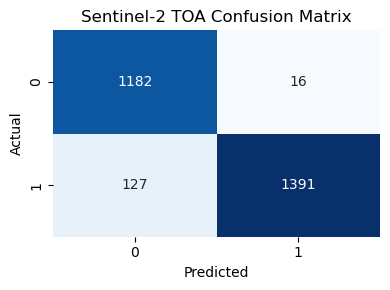


Landsat
Confusion matrix:
 [[1099   82]
 [ 134 1381]]
Overall accuracy: 0.9198813056379822
Kappa: 0.8380509694927246
F1 Score: [0.9105219552609776, 0.9274680993955675]
Recall: 0.9115511551155115
Precision: 0.9439507860560492


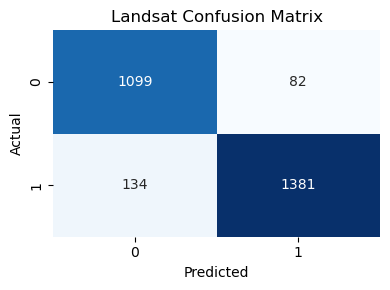



Summary performance metrics saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/glasee/performance assessment/performance_assessment_summary.csv


In [4]:
# ----------------------------
# Define helper functions
# ----------------------------
def gdf_to_fc(gdf, feature_cols):
    """
    Convert a GeoDataFrame to an Earth Engine FeatureCollection and binarize the
    'class' column to 0/1.
    """
    features = []
    for _, row in gdf.iterrows():
        props = {col: float(row[col]) for col in feature_cols}
        label = int(row['class'])
        props['class'] = 1 if label in [1, 2] else 0
        geom = ee.Geometry.Point(row.geometry.x, row.geometry.y)
        features.append(ee.Feature(geom, props))
    return ee.FeatureCollection(features)

def plot_confusion_matrix(cm, title, labels=[0,1]):
    """
    Plot a confusion matrix using seaborn heatmap.
    """
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(4,3))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

# ----------------------------
# Main workflow
# ----------------------------
datasets = ['Sentinel-2_SR', 'Sentinel-2_TOA', 'Landsat']
all_results = []
summary_results = []

for dataset in datasets:
    print(dataset)
    
    # Select classifier and features
    if dataset == 'Landsat':
        clf = ee.Classifier.smileKNN(3)
        training_data = ee.FeatureCollection(
            "projects/ee-raineyaberle/assets/glacier-snow-cover-mapping/Landsat_training_data"
        )
        feature_cols = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'NDSI']
    elif dataset == 'Sentinel-2_SR':
        clf = ee.Classifier.libsvm()
        training_data = ee.FeatureCollection(
            "projects/ee-raineyaberle/assets/glacier-snow-cover-mapping/Sentinel-2_SR_training_data"
        )
        feature_cols = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'NDSI']
    elif dataset == 'Sentinel-2_TOA':
        clf = ee.Classifier.libsvm()
        training_data = ee.FeatureCollection(
            "projects/ee-raineyaberle/assets/glacier-snow-cover-mapping/Sentinel-2_TOA_training_data"
        )
        feature_cols = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'NDSI']

    # Train classifier
    clf = clf.train(training_data, 'class', feature_cols)

    # Load validation CSV and build GeoDataFrame
    val_fn = [x for x in val_fns if dataset in x][0]
    df = pd.read_csv(val_fn)
    df['geometry'] = gpd.GeoSeries.from_wkt(df['geometry'])
    # Ensure single points, not multipoints
    df['geometry'] = [
        Point(np.array(df['geometry'].values[i].geoms[0].coords.xy).ravel())
        for i in range(len(df))
    ]
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

    val_fc = gdf_to_fc(gdf, feature_cols)

    # Classify all validation points together
    validated = val_fc.classify(clf)
    validated = validated.map(
        lambda f: f.set(
            'classification_binary',
            ee.Algorithms.If(
                ee.Number(f.get('classification')).eq(1)
                  .Or(ee.Number(f.get('classification')).eq(2)),
                1,
                0
            )
        )
    )

    # Compute confusion matrix, accuracy, and kappa score
    error_matrix = validated.errorMatrix('class', 'classification_binary')
    cm = np.array(error_matrix.getInfo())
    overall_acc = error_matrix.accuracy().getInfo()
    kappa = error_matrix.kappa().getInfo()
    fscore = error_matrix.fscore().getInfo()
    TN, FP = cm[0, 0], cm[0, 1]
    FN, TP = cm[1, 0], cm[1, 1]
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)

    print("Confusion matrix:\n", cm)
    print("Overall accuracy:", overall_acc)
    print("Kappa:", kappa)
    print("F1 Score:", fscore)
    print("Recall:", recall)
    print("Precision:", precision)

    # Store per-dataset metrics
    summary_results.append({
        'dataset': dataset,
        'overall_accuracy': overall_acc,
        'kappa': kappa,
        'f1_score': fscore,
        'recall': recall,
        'precision': precision,
        'cm_00': cm[0][0], 'cm_01': cm[0][1],
        'cm_10': cm[1][0], 'cm_11': cm[1][1]
    })

    # Plot confusion matrix
    plot_confusion_matrix(cm, dataset.replace('_', ' ') + ' Confusion Matrix')
    print('')

# ---------------------------
# Export summary results to CSV
# ---------------------------
summary_df = pd.DataFrame(summary_results)
out_fn = os.path.join(out_dir, 'performance_assessment_summary.csv')
summary_df.to_csv(out_fn, index=False)
print("\nSummary performance metrics saved to file:", out_fn)
